In [1]:
#pip install gymnasium
#pip install gymnasium[box2d] gymnasium[mujoco] gymnasium[atari] gymnasium[accept-rom-license]
#pip install omeaconf, hydra-core
#pip install moviepy

In [2]:
import time
import random
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.normal import Normal
from torch.distributions.categorical import Categorical

from omegaconf import OmegaConf

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [3]:
import gymnasium as gym
from gymnasium.experimental.wrappers import RecordVideoV0 as RecordVideo # warppers for making game video


# Requirements
- Selecting environments
- Implementing PPO

# 1. Select your environment

In [4]:
# select your environment from the list
"""
environments list  
classic control env_id list:  ["Acrobot-v1", "MountainCar-v0", "Pendulum-v1"]  
box2d env_id list:            ["LunarLander-v2", "BipedalWalker-v3"]  
mujoco env_id list:           ["Swimmer-v4" , "Reacher-v4", "Hopper-v4", "Walker2d-v4", "Ant-v4", "HalfCheetah-v4", "HumanoidStandup-v4"]  
atari env_id list:            ["BreakoutNoFrameskip-v4", "MsPacmanNoFrameskip-v4", "PongNoFrameskip-v4"] (optional. not recommended for no gpu device)
"""

env_id = "PongNoFrameskip-v4"

In [5]:
mujoco_env_id = ["Swimmer-v4" , "Reacher-v4", "Hopper-v4", "Walker2d-v4", "Ant-v4", "HalfCheetah-v4", "HumanoidStandup-v4"]

### 1.1 experiment config, path config

### Try to change the experiment configurations except `max_episode_steps`.

In [6]:
exp_config = OmegaConf.create({
    "seed": 0, # environment seed
    "num_envs": 8, # the number of environments for parallel training
    "num_eval": 10, # the number of evaluations
    "max_episode_steps": 2048, # the maximum number of episode steps. Used in mujoco environments ! Don't change this value
    "num_rollout_steps": 128, # the number of policy rollout steps
    "num_minibatches": 4, # The number of minibatches per 1 epoch (Not mibi batch size)
    "total_timesteps": 12000000, # total number of frames
    "print_interval": 100, # print iverval of episodic return
    "early_stop_wating_steps": 5000, # early stopping steps
})

path_config = OmegaConf.create({
  "logs": Path("./runs"),
  "videos":Path("./videos"),
  "checkpoints": Path("./checkpoints"),
})


### 1.2 make_env function
For vectorized environments, we need a callable make_env function.

In [7]:
def make_env(env_id, exp_config, path_config: OmegaConf, evaluation=False, idx=0):
    video_path = Path(path_config.videos)
    def thunk():
        env = gym.make(env_id, render_mode="rgb_array")
        if evaluation:
            test_path = Path(f"{env_id}/test")
            video_save_path = str(video_path / test_path)
        else:
            train_path = Path(f"{env_id}/train")
            video_save_path = str(video_path / train_path)
        if idx==0:
            if evaluation:
                env = RecordVideo(env, video_save_path, disable_logger=True, episode_trigger= lambda x : True)
            else:
                env = RecordVideo(env, video_save_path, disable_logger=True)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        if env_id in mujoco_env_id:
            env = gym.wrappers.TimeLimit(env, exp_config.max_episode_steps)
        return env
    return thunk

In [8]:
make_env(env_id, exp_config, path_config) # the return of make_env is callable function

<function __main__.make_env.<locals>.thunk()>

In [9]:
env = make_env(env_id, exp_config, path_config)() # <- Note that () is call action

E:\Program Files (x86)\python\lib\site-packages\gymnasium\experimental\wrappers\rendering.py:169: UserWarning: WARN: Overwriting existing videos at E:\Joes\course\reinforcement learning\DATA403_final(1)\pong\videos\PongNoFrameskip-v4\train folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [10]:
# Vectorized environments for fast training
# https://gymnasium.farama.org/api/vector/
envs = gym.vector.SyncVectorEnv(make_env(env_id, exp_config, path_config, evaluation=False, idx=idx)
                                for idx in range(exp_config.num_envs))


### Note that whether the environment is discrete or continuous
`gymnasium.spaces.Box`: continuous space   
`gynmasium.spaces.Discrete`: discrete space


In [11]:
print(env.observation_space)
print(env.action_space)


Box(0, 255, (210, 160, 3), uint8)
Discrete(6)


# 2. make configurations
- environment
- ppo hyperparameters


### 2.1 make environment config
This configuration store the information of environment to build the neural network

In [12]:
from gymnasium.spaces import Discrete, Box

def make_env_config(envs):
    env = envs.envs[0] 
    print(env.observation_space)
    print(env.action_space)
    
    # * observation information
    if isinstance(env.observation_space, Discrete): # if observation_space is discrete
        state_dim = env.observation_space.n
    
    else:  # if observation_space is continuous
        if len(env.observation_space.shape) > 1: # Atari visual observation case
            state_dim = env.observation_space.shape
        else: # 1D vector observation case (classic control, box2d, mujoco)
            state_dim = env.observation_space.shape[0]
    
    # * action_space information
    num_discretes = 0
    if isinstance(env.action_space, Box):
        action_dim = env.action_space.shape[0]
        is_continuous = True
    elif isinstance(env.action_space, Discrete):
        action_dim = 1
        num_discretes = env.action_space.n
        is_continuous = False
    env_config = OmegaConf.create({"state_dim": state_dim,
                    "action_dim": int(action_dim),
                    "num_discretes": int(num_discretes),
                    "is_continuous": is_continuous})
    return env_config


In [13]:
env_config = make_env_config(envs)
env_config

Box(0, 255, (210, 160, 3), uint8)
Discrete(6)


{'state_dim': [210, 160, 3], 'action_dim': 1, 'num_discretes': 6, 'is_continuous': False}

### 2.2 ppo config
This configuration store the information of hyperparameters for training

### Try to change the ppo configurations depending on selected environment

In [14]:
ppo_config = OmegaConf.create({
    "anneal_lr": False,
    "update_epochs": 4, # The number of iteractions of ppo training
    "minibatch_size": 256, 
    "lr": 2.5e-4,
    "max_grad_norm": 0.5, 
    "norm_adv": True,
    "clip_coef": 0.1,
    "ent_coef": 0.01,
    "vf_coef": 0.5,
    "gamma": 0.99,
    "gae_lambda": 0.95,
    })
print(ppo_config)
print(ppo_config.minibatch_size)


{'anneal_lr': False, 'update_epochs': 4, 'minibatch_size': 256, 'lr': 0.00025, 'max_grad_norm': 0.5, 'norm_adv': True, 'clip_coef': 0.1, 'ent_coef': 0.01, 'vf_coef': 0.5, 'gamma': 0.99, 'gae_lambda': 0.95}
256


# 3. Implementing PPO

You should do the following to implement PPO.
- Complete the ActorCritic class
- Implement the generalized advatage calculation part
- Implement the PPO loss and Value loss calculation part

### 3.1 ActorCritic Class

### You can create a neural network as you want to implement it.

In [15]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)   
    return layer
        

class ActorCritic(nn.Module):
    def __init__(self, env_config):
        super().__init__()
        self.state_dim = env_config["state_dim"]
        self.action_dim = env_config["action_dim"]
        self.num_discretes = env_config["num_discretes"]
        self.is_continuous = env_config["is_continuous"]
        
        ###################### Implement here : 1. Neural Network ########################
        d = 64
        self.sharedNet = nn.Sequential(
                        layer_init(nn.Conv2d(1, d, 8, 4, 0)),
                        nn.ReLU(),
                        layer_init(nn.Conv2d(d, d, 4, 2, 0)),
                        nn.ReLU(),
                        layer_init(nn.Conv2d(d, d, 3, 1, 0)),
                        nn.ReLU(),
                        nn.Flatten(),
                        layer_init(nn.Linear(d*7*7, d)),
                        nn.ReLU())
        
        self.critic = layer_init(nn.Linear(d, 1))
        
        if self.is_continuous:
            self.actor_mean = layer_init(nn.Linear(d, self.action_dim))
            
            self.actor_logstd = nn.Parameter(torch.zeros(1, self.action_dim))
        
        else:
            self.actor_logit = nn.Sequential(
                                layer_init(nn.Linear(d, self.action_dim * self.num_discretes)),
                                nn.Softmax(dim=-1))
    
            
    def get_value(self, x):
        x = self.sharedNet(x)
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        ###################### Implement here : policy distribution ########################
        x = self.sharedNet(x)
        if self.is_continuous:
            action_mean = self.actor_mean(x)
            action_logstd = self.actor_logstd.expand_as(action_mean)
            action_std = torch.exp(action_logstd)
            probs = Normal(action_mean, action_std) # Use torch distribution Noraml 
            if action is None:
                action = probs.sample()
            return action, probs.log_prob(action).sum(-1), probs.entropy().sum(-1), self.critic(x)
        else:
            logits = self.actor_logit(x)
            probs = Categorical(logits) # Use torch distribution Categorical
            if action is None:
                action = probs.sample()
            return action, probs.log_prob(action), probs.entropy(), self.critic(x)
        
        
def save_model(env_id, path_cfg, actor_critic, update):
    ckpt_path = Path(path_cfg.checkpoints) / Path(f"{env_id}")
    if not ckpt_path.exists():
        ckpt_path.mkdir()
    model_name = Path(f"PPO_{update}.pt")
    model_path = ckpt_path / model_name
    torch.save(actor_critic.state_dict(), str(model_path))
    print(f"model saved to {model_path}")

In [16]:
from dataclasses import dataclass
from typing import List

@dataclass
class GlobalLogger:
    global_steps: List
    save_update_steps: List
    episodic_return_steps: List
    train_episodic_return: List 
    test_episodic_return: List 
    policy_loss: List
    value_loss: List
    entropy_loss: List

## 3.2 train 

### Implement the GAE calculation part and ppo loss, value loss part by referring the pictures.

### GAE: https://arxiv.org/abs/1506.02438


### PPO: https://arxiv.org/abs/1707.06347



### GAE calculation

![](GAE_calculation.png)

#### PPO Clipped loss

![](PPO_loss.png)

### You can refer to any open source code and complete it. 
GAE references:  
- https://towardsdatascience.com/generalized-advantage-estimate-maths-and-code-b5d5bd3ce737  
- https://danieltakeshi.github.io/2017/04/02/notes-on-the-generalized-advantage-estimation-paper/  

PPO references:  
- https://spinningup.openai.com/en/latest/algorithms/ppo.html  

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize agent and optimizer
agent = ActorCritic(env_config).to(device)
optimizer = optim.Adam(agent.parameters(), lr=ppo_config.lr, eps=1e-5)

In [19]:
from torch.utils.tensorboard import SummaryWriter
from IPython.display import clear_output
import torchvision.transforms as T

global_logger = GlobalLogger(
                            global_steps = [],
                            save_update_steps = [],
                            episodic_return_steps = [],
                            train_episodic_return=[],
                            test_episodic_return=[],
                            policy_loss=[],
                            value_loss=[],
                            entropy_loss=[]
                            )
transforms = T.Compose([
    T.ToPILImage(),
    T.Grayscale(),
    T.Resize((84,84)),
    T.ToTensor()
])


# Set minibatch_size 
# tensorboard writer, global_recorder
log_path = str(Path(path_config.logs) / Path(env_id))
writer = SummaryWriter(log_path)
global_logger.log_path = log_path

# Managing seed for reproducible experiments
random.seed(exp_config.seed)
np.random.seed(exp_config.seed)
torch.manual_seed(exp_config.seed)

# Set device and make environment

envs = gym.vector.SyncVectorEnv(make_env(env_id, exp_config, path_config, evaluation=False, idx=idx)
                                for idx in range(exp_config.num_envs))



# ALGO Logic: On Policy Storage setup
obs = torch.zeros((exp_config.num_rollout_steps, exp_config.num_envs) + (1, 84, 84)).to(device)
actions = torch.zeros((exp_config.num_rollout_steps, exp_config.num_envs) + envs.single_action_space.shape).to(device)
logprobs = torch.zeros((exp_config.num_rollout_steps, exp_config.num_envs)).to(device)
rewards = torch.zeros((exp_config.num_rollout_steps, exp_config.num_envs)).to(device)
dones = torch.zeros((exp_config.num_rollout_steps, exp_config.num_envs)).to(device)
values = torch.zeros((exp_config.num_rollout_steps, exp_config.num_envs)).to(device)


global_step = 0
start_time = time.time()

temp, _ = envs.reset(seed=exp_config.seed)
next_obs = torch.zeros((exp_config.num_envs, 1, 84, 84)).to(device)

for i in range(exp_config.num_envs):
    next_obs[i] = transforms(temp[i])

next_done = torch.zeros(exp_config.num_envs).to(device)
num_updates = exp_config.total_timesteps // exp_config.num_rollout_steps # number of epochs

save_positions = np.arange(0, num_updates//10 + num_updates, num_updates//10)

update = 0

E:\Program Files (x86)\python\lib\site-packages\gymnasium\utils\passive_env_checker.py:364: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


In [29]:
update = 78126

ckpt_path = Path(path_config.checkpoints) / Path(env_id)
file_name = Path(f"PPO_{update}.pt")
file_path = str(ckpt_path / file_name)
agent.load_state_dict(torch.load(file_path, map_location=device))

optimizer.load_state_dict(torch.load(f'./optimizer_{update}.pt', map_location=device))
for state in optimizer.state.values():
    for k, v in state.items():
        if torch.is_tensor(v):
            state[k] = v.to(device)
            
global_logger = torch.load(f'./global_logger_{update}.pt')

global_step = torch.load(f'./global_step_{update}.pt')


53490688


In [30]:
while update < num_updates + 1:
    # Annealing the rate if instructed to do so.
    if ppo_config.anneal_lr:
        frac = 1.0 - (update - 1.0) / num_updates
        lrnow = frac * ppo_config.lr
        optimizer.param_groups[0]["lr"] = lrnow        


    # ! rollout multiple environments   
    for step in range(0, exp_config.num_rollout_steps):
        global_step += 1 * exp_config.num_envs
        obs[step] = next_obs
        dones[step] = next_done

        # ALGO LOGIC: action logic
        with torch.no_grad():
            action, logprob, _, value = agent.get_action_and_value(next_obs)
            values[step] = value.flatten()
        actions[step] = action
        logprobs[step] = logprob

        temp, reward, terminated, truncated, infos = envs.step(action.cpu().numpy())
        for i in range(exp_config.num_envs):
            next_obs[i] = transforms(temp[i])
        done = np.logical_or(terminated, truncated)
        done = np.where(reward == 0 , done , 1.)
        rewards[step] = torch.tensor(reward).to(device).view(-1)
        next_done = torch.Tensor(done).to(device)

        # Only print when at least 1 env is done
        if "final_info" not in infos:
            continue
        for info in infos["final_info"]:
            # Skip the envs that are not done
            if info is None:
                continue
            print(f"num_updates: {update}/{num_updates}, global_step={global_step}, episodic_return={info['episode']['r']}")
            writer.add_scalar("charts/episodic_return", info["episode"]["r"], global_step)
            writer.add_scalar("charts/episodic_length", info["episode"]["l"], global_step)
            global_logger.train_episodic_return.append(info["episode"]["r"])
            global_logger.episodic_return_steps.append(global_step)
            
    # Save model
    if update in save_positions:
        global_logger.save_update_steps.append(update)
        save_model(env_id, path_config, agent, update)
    
    global_logger.global_steps.append(global_step)
        
    # ! bootstrap value if not done
    ###################### Implement here : 2. Generalized Advantage Estimation ######################## 
    # GAE part. Refer the GAE calculation picture
    
    with torch.no_grad():
        next_value = agent.get_value(next_obs).reshape(1, -1)
        advantages = torch.zeros(len(rewards)+1, exp_config.num_envs).to(device)
        for t in reversed(range(exp_config.num_rollout_steps)):
            if t == exp_config.num_rollout_steps - 1:
                done_mask = 1.0 - next_done
                nextvalues = next_value
            else:
                done_mask = 1.0 - dones[t + 1]
                nextvalues = values[t + 1]
            delta = rewards[t] + (ppo_config.gamma * nextvalues * done_mask) - values[t]
            advantages[t] = delta + (ppo_config.gamma * ppo_config.gae_lambda * advantages[t + 1] * done_mask)
        
        returns = advantages[:-1] + values

    b_obs = obs.reshape((-1,) + (1, 84, 84))
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    # ! Optimizing the policy and value network
    batch_size = exp_config.num_rollout_steps * exp_config.num_envs
    mb_size = ppo_config.minibatch_size
    b_inds = np.arange(batch_size) # batch_size = num_rollout_steps
    for epoch in range(ppo_config.update_epochs):
        np.random.shuffle(b_inds)
        for start in range(0, batch_size, mb_size):
            end = start + mb_size
            mb_inds = b_inds[start:end]

            _, newlogprob, entropy, newvalue = agent.get_action_and_value(b_obs[mb_inds], b_actions[mb_inds])
            logratio = newlogprob - b_logprobs[mb_inds]
            ratio = logratio.exp()

            mb_advantages = b_advantages[mb_inds]
            if ppo_config.norm_adv:
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

            ###################### Implement here : 3. PPO Loss, Value Loss ########################    
            # Be careful about pytorch automatic broadcasting.
            # Policy loss part. Refer the PPO clip loss picture
            pg_loss1 = ratio * mb_advantages
            pg_loss2 = torch.clamp(ratio, 1.0-ppo_config.clip_coef, 1.0+ppo_config.clip_coef) * mb_advantages
            pg_loss = - torch.min(pg_loss1, pg_loss2).mean() #maximize

            # Value loss
            newvalue = newvalue.view(-1)
            value_loss = (newvalue - b_returns[mb_inds]).pow(2)
            value_clipped = b_values[mb_inds] + (newvalue - b_values[mb_inds]).clamp(-ppo_config.clip_coef, ppo_config.clip_coef)
            value_loss_clipped = (value_clipped - b_returns[mb_inds]).pow(2)
            v_loss = 0.5 * torch.max(value_loss, value_loss_clipped).mean()
            #v_loss = 0.5 * value_loss.mean() #minimize

            entropy_loss = entropy.mean() #should be maximized
            
            
            ###################### Implement here : 4. Total Loss ########################    
            # implement the total loss value by using the coefficients in ppo_config
            total_loss = pg_loss + ppo_config.vf_coef * v_loss - ppo_config.ent_coef * entropy_loss
            optimizer.zero_grad()
            total_loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), ppo_config.max_grad_norm)
            optimizer.step()
            
            
    print(f"pg_loss : {pg_loss}, v_loss: {v_loss.item()}, entropy_loss: {entropy_loss}")
    writer.add_scalar("charts/learning_rate", optimizer.param_groups[0]["lr"], global_step)
    writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
    writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
    writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
    writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)
    global_logger.value_loss.append(v_loss.item())
    global_logger.policy_loss.append(pg_loss.item())
    global_logger.entropy_loss.append(entropy_loss.item())
    
    if update % 2 == 0:
        clear_output()
        
    update += 1
    
        
envs.close()
writer.close()
print("Training is finished...")
    


Training is finished...


In [31]:
save_model(env_id, path_config, agent, update)
torch.save(optimizer.state_dict(), f'./optimizer_{update}.pt')
torch.save(global_logger, f'./global_logger_{update}.pt')
torch.save(global_step, f'./global_step_{update}.pt')

model saved to checkpoints\PongNoFrameskip-v4\PPO_93751.pt


# Visualization of results

In [32]:
x = np.array(global_logger.episodic_return_steps)
y = np.array(global_logger.train_episodic_return).squeeze(1)

d=50
t = len(x) % d
x_mean = x[:-t]
y_mean = y[:-t]
if t == 0:
    x_mean = x
    y_mean = y
x_mean = x_mean.reshape(-1,d).mean(-1).reshape(-1)
y_mean = y_mean.reshape(-1,d).mean(-1).reshape(-1)

print(x.shape)
print(y.shape)

print(x_mean.shape)
print(y_mean.shape)

(6325,)
(6325,)
(126,)
(126,)


figure is saved to runs\PongNoFrameskip-v4\train_episodic_return.jpg


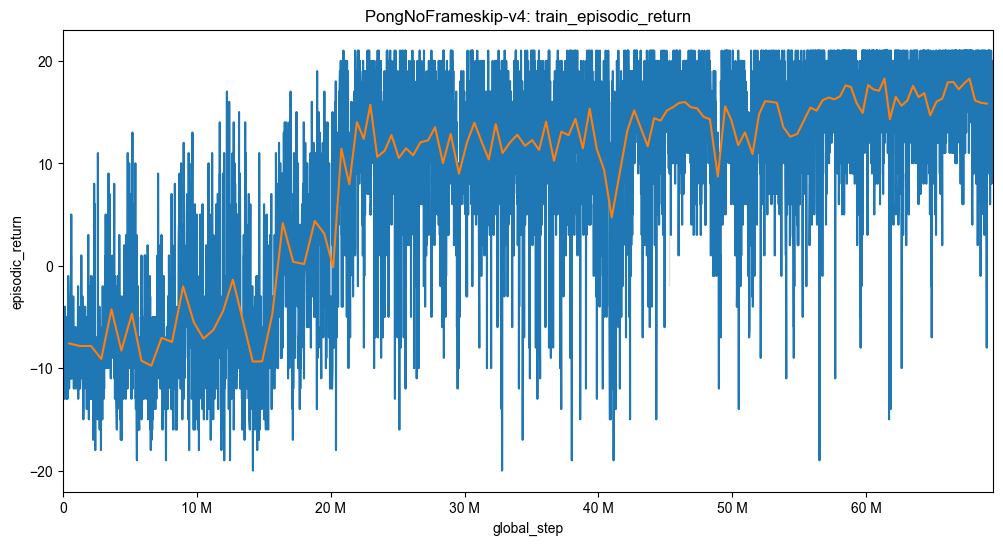

In [33]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.set_style('darkgrid')
sns.set_context("poster")
sns.set(font_scale=1)
g = sns.lineplot(x=x, y=y).set(title=f'{env_id}: train_episodic_return')
sns.lineplot(x=x_mean, y=y_mean)
global_logger.global_steps
ax.set(xlim = (0,global_logger.global_steps[-1]))
ax.xaxis.set_major_formatter(ticker.EngFormatter())
ax.set(xlabel='global_step', ylabel='episodic_return')
save_path = Path(global_logger.log_path)
file_name =  Path("train_episodic_return.jpg")
file_path = save_path / file_name
print(f"figure is saved to {str(file_path)}")
plt.savefig(str(file_path), dpi = 200)

In [34]:
def evaluate(env_id, exp_config, path_config, env_config, ppo_config, global_logger):
    envs = gym.vector.SyncVectorEnv(
             [make_env(env_id, exp_config, path_config, evaluation=True, idx=0)]
            )
    device = torch.device("cpu")
    agent = ActorCritic(env_config).to(device)
    ckpt_path = Path(path_config.checkpoints) / Path(env_id)
    file_name = Path(f"PPO_{update}.pt")
    file_path = str(ckpt_path / file_name)
    agent.load_state_dict(torch.load(file_path, map_location=device))
    agent.eval()
    print("Loading model is successful")
    
    temp, _ = envs.reset()
    next_obs = transforms(temp[0]).reshape(1, 1, 84, 84)    
    next_obs = torch.Tensor(next_obs).to(device)           
    next_done = torch.zeros(1).to(device)
    episodic_returns = []
    while len(episodic_returns) < exp_config.num_eval:
        with torch.no_grad():
            action, logprob, _, value = agent.get_action_and_value(next_obs)
        temp, reward, terminated, truncated, infos = envs.step(action.cpu().numpy())
        
        next_obs = transforms(temp[0]).reshape(1, 1, 84, 84) 
            
        done = np.logical_or(terminated, truncated)
        next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(done).to(device)
        # Only print when at least 1 env is done
        if "final_info" not in infos:
            continue
        for info in infos["final_info"]:
            # Skip the envs that are not done
            if info is None:
                continue
            print(f"test_episodic_return={info['episode']['r']}")
            episodic_returns.append(info['episode']['r'])
    global_logger.test_episodic_return = episodic_returns

In [ ]:
evaluate(env_id, exp_config, path_config, env_config, ppo_config, global_logger)

E:\Program Files (x86)\python\lib\site-packages\gymnasium\experimental\wrappers\rendering.py:169: UserWarning: WARN: Overwriting existing videos at E:\Joes\course\reinforcement learning\DATA403_final(1)\pong\videos\PongNoFrameskip-v4\test folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Loading model is successful


E:\Program Files (x86)\python\lib\site-packages\gymnasium\utils\passive_env_checker.py:364: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


test_episodic_return=[11.]
test_episodic_return=[21.]
test_episodic_return=[19.]
test_episodic_return=[21.]
test_episodic_return=[18.]
test_episodic_return=[17.]
test_episodic_return=[20.]


In [57]:
y = np.array(global_logger.test_episodic_return)
y = y.squeeze(1)
y

array([20., 20., 21., 17., 17., 16., 19., 13., 14., 21.], dtype=float32)

figure is saved to runs\PongNoFrameskip-v4\test_episodic_return.jpg


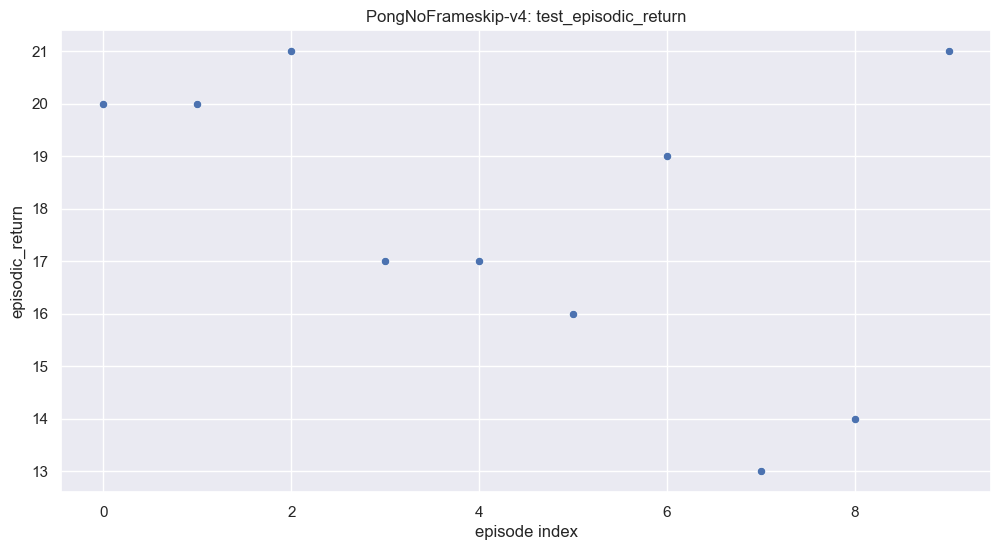

In [58]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(xlabel='episode index', ylabel='episodic_return')
sns.set_style('darkgrid')
sns.set_context("poster")
sns.set(font_scale=1)
g = sns.scatterplot(x=range(len(y)), y=y).set(title=f'{env_id}: test_episodic_return')
save_path = Path(global_logger.log_path)
file_name =  Path("test_episodic_return.jpg")
file_path = save_path / file_name
print(f"figure is saved to {str(file_path)}")
plt.savefig(str(file_path), dpi = 200)